# Local Dynamics of COVID-19 Transmission in Queensland

In [1]:
#Import Libraries
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="whitegrid")

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

# Read in the Data (Downloaded from 10/08/2025)
# File path omitted for privacy/security
df_age = pd.read_csv(r'...\opendata_qld_covidcase_agegrp.csv')
# SA2_CODE contains both string and numeral, which was set to float64
df_loc = pd.read_csv(r'...\opendata_qld_covidcase_loc.csv',
    dtype={'SA2_CODE': 'float64'}, low_memory=False
)

## Analyse Table Contents

In [2]:
df_age.head()

,_id,NOTIFICATION_DATE,AGE_GROUP_5Y
0,1,28/01/2020,40-44 years
1,2,30/01/2020,40-44 years
2,3,04/02/2020,35-39 years
3,4,04/02/2020,05-09 years
4,5,06/02/2020,35-39 years


In [3]:
df_loc.head()

,_id,NOTIFICATION_DATE,HHS,POSTCODE,LGA_NAME,SOURCE_INFECTION,SA2_CODE,SA2_REGION
0,1,28/01/2020,GOLD COAST,NaN,NaN,Overseas Acquired,NaN,NaN
1,2,30/01/2020,GOLD COAST,NaN,NaN,Overseas Acquired,NaN,NaN
2,3,04/02/2020,GOLD COAST,NaN,NaN,Locally acquired - contact of confirmed case a...,NaN,NaN
3,4,04/02/2020,GOLD COAST,NaN,NaN,Locally acquired - contact of confirmed case a...,NaN,NaN
4,5,06/02/2020,GOLD COAST,NaN,NaN,Locally acquired - contact of confirmed case a...,NaN,NaN


In [4]:
df_age.dtypes

_id                   int64
NOTIFICATION_DATE    object
AGE_GROUP_5Y         object
dtype: object

In [5]:
df_loc.dtypes

_id                    int64
NOTIFICATION_DATE     object
HHS                   object
POSTCODE             float64
LGA_NAME              object
SOURCE_INFECTION      object
SA2_CODE             float64
SA2_REGION            object
dtype: object

In [6]:
# Define and call function to check missing values in age groups table
missing_df_age = df_age.isnull().sum()
null_percent_df_age = df_age.isnull().mean() * 100

def print_missing_info(title, df):
    print(title)
    print(df)
    print()

print_missing_info("Number of Missing Nulls in Age Groups Table", missing_df_age)
print_missing_info("Number of Missing Nulls in Age Group Table", 
                   null_percent_df_age.apply(lambda x: f"{x:.6f}%"))


Number of Missing Nulls in Age Groups Table
_id                   0
NOTIFICATION_DATE     0
AGE_GROUP_5Y         13
dtype: int64

Number of Missing Nulls in Age Group Table
_id                  0.000000%
NOTIFICATION_DATE    0.000000%
AGE_GROUP_5Y         0.000701%
dtype: object



In [7]:
# Define and call function to check missing values in location table
missing_df_loc = df_loc.isnull().sum()
null_percent_df_loc = (df_loc.isnull().mean() * 100).round(2)

def print_missing_info(title, df):    
    print(title)
    print(df)
    print()

print_missing_info("Number of Missing Nulls in Location & Source of Infection Table", missing_df_loc)
print_missing_info("Percentage of Missing Nulls in Location & Source of Infection Table", 
                   null_percent_df_loc.apply(lambda x: f"{x}%"))


Number of Missing Nulls in Location & Source of Infection Table
_id                       0
NOTIFICATION_DATE         0
HHS                       0
POSTCODE              27081
LGA_NAME              27110
SOURCE_INFECTION          0
SA2_CODE             319777
SA2_REGION           319775
dtype: int64

Percentage of Missing Nulls in Location & Source of Infection Table
_id                    0.0%
NOTIFICATION_DATE      0.0%
HHS                    0.0%
POSTCODE              1.46%
LGA_NAME              1.46%
SOURCE_INFECTION       0.0%
SA2_CODE             17.25%
SA2_REGION           17.25%
dtype: object



In [8]:
# list all unique names while excluding missing values using dropna()
def print_distinct_values(df, columns, label):
    for col in columns:
        distinct_values = df[col].dropna().unique()
        print(f"{label} Column: {col}")
        print(f"Distinct names ({len(distinct_values)}): {distinct_values}\n")

# For df_age (all columns)
print_distinct_values(df_age, df_age.columns, "Age Groups")

# For df_loc (specific columns)
columns_to_count = ['HHS', 'LGA_NAME', 'SOURCE_INFECTION']
print_distinct_values(df_loc, columns_to_count, "Location Infection")



Age Groups Column: _id
Distinct names (1854305): [      1       2       3 ... 1854303 1854304 1854305]

Age Groups Column: NOTIFICATION_DATE
Distinct names (1786): ['28/01/2020' '30/01/2020' '04/02/2020' ... '03/08/2025' '04/08/2025'
 '05/08/2025']

Age Groups Column: AGE_GROUP_5Y
Distinct names (21): ['40-44 years' '35-39 years' '05-09 years' '55-59 years' '50-54 years'
 '60-64 years' '65-69 years' '25-29 years' '20-24 years' '80-84 years'
 '30-34 years' '45-49 years' '70-74 years' '75-79 years' '00-04 years'
 '15-19 years' '10-14 years' '85-89 years' '90-94 years' '95-99 years'
 '100+ years']

Location Infection Column: HHS
Distinct names (17): ['GOLD COAST' 'WIDE BAY' 'METRO NORTH' 'SUNSHINE COAST' 'METRO SOUTH'
 'DARLING DOWNS' 'CENTRAL QUEENSLAND' 'WEST MORETON' 'TOWNSVILLE' 'MACKAY'
 'CAIRNS AND HINTERLAND' 'INTERSTATE' 'TORRES AND CAPE' 'SOUTH WEST'
 'NORTH WEST' 'CENTRAL WEST' 'COMMUNICABLE DISEASES BRANCH']

Location Infection Column: LGA_NAME
Distinct names (78): ['Bundaberg 

In [9]:
# Count the occurrences of each unique name and calculate its percentage of the total

def print_column_value_percents(df, columns, label, decimals=1, include_na=False):
    total = len(df)
    print(f"\nCounts and Percentages for {label} Table (base = {total:,} rows)")
    for col in columns:
        print(f"\nColumn: {col}")
        # Include or drop NaN as a category
        counts = df[col].value_counts(dropna=not include_na)
        # header row
        print(f"{'Value':<70}{'Count':>12}{'Percent':>12}")
        print("-" * 94)
        for value, count in counts.items():
            pct = (count / total) * 100 if total else 0.0
            name = "NA" if pd.isna(value) else str(value)
            # Print row with fixed-width columns for clear visual alignment
            print(f"{name:<70}{count:>12,}{pct:>11.{decimals}f}%")
        # If excluding NaNs, still show how many are missing
        if not include_na:
            missing = df[col].isna().sum()
            if missing:
                mp = (missing / total) * 100
                print(f"{'Missing':<70}{missing:>12,}{mp:>11.{decimals}f}%")

# Age Groups
print_column_value_percents(df_age, ['AGE_GROUP_5Y'], 'Age Groups')

# Location & Source of Infection
columns_to_count = ['HHS', 'LGA_NAME', 'SOURCE_INFECTION']
print_column_value_percents(df_loc, columns_to_count, 'Location & Source of Infection')


Counts and Percentages for Age Groups Table (base = 1,854,305 rows)

Column: AGE_GROUP_5Y
Value                                                                        Count     Percent
----------------------------------------------------------------------------------------------
25-29 years                                                                164,448        8.9%
30-34 years                                                                163,220        8.8%
35-39 years                                                                161,068        8.7%
20-24 years                                                                157,910        8.5%
40-44 years                                                                147,097        7.9%
45-49 years                                                                133,225        7.2%
15-19 years                                                                124,033        6.7%
50-54 years                                           

In [10]:
# Check for inconsistencies between HHS and LGA
df_loc[['HHS', 'LGA_NAME']].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

,HHS,LGA_NAME,count
0,METRO SOUTH,Brisbane City,249570
1,METRO NORTH,Brisbane City,222694
2,GOLD COAST,Gold Coast City,215407
3,METRO NORTH,Moreton Bay Regional,179967
4,METRO SOUTH,Logan City,128136
...,...,...,...
407,CENTRAL QUEENSLAND,Charters Towers Regional,1
408,TOWNSVILLE,South Burnett Regional,1
409,WEST MORETON,Northern Peninsula Area Regional,1
410,WEST MORETON,Bulloo Shire,1


In [11]:
# Search for unusual combinations
# Example: cases where Gold Coast LGA appears with non-Gold Coast HHS
df_loc[(df_loc['LGA_NAME'] == 'Brisbane City') &
    (~df_loc['HHS'].isin(['METRO NORTH', 'METRO SOUTH']))
]

,_id,NOTIFICATION_DATE,HHS,POSTCODE,LGA_NAME,SOURCE_INFECTION,SA2_CODE,SA2_REGION
364,365,22/03/2020,WEST MORETON,4306.0,Brisbane City,Locally acquired - contact of confirmed case a...,310031290.0,Karana Downs
368,369,22/03/2020,WEST MORETON,4306.0,Brisbane City,Locally acquired - contact of confirmed case a...,310031290.0,Karana Downs
369,370,22/03/2020,WEST MORETON,4306.0,Brisbane City,Locally acquired - contact of confirmed case a...,310031290.0,Karana Downs
389,390,23/03/2020,WEST MORETON,4306.0,Brisbane City,Overseas Acquired,310031290.0,Karana Downs
489,490,24/03/2020,WEST MORETON,4306.0,Brisbane City,Locally acquired - contact of confirmed case a...,310031290.0,Karana Downs
...,...,...,...,...,...,...,...,...
1852476,1852477,25/07/2025,WEST MORETON,4076.0,Brisbane City,Under Investigation,NaN,NaN
1853456,1853457,31/07/2025,WEST MORETON,4306.0,Brisbane City,Under Investigation,NaN,NaN
1853689,1853690,01/08/2025,WEST MORETON,4306.0,Brisbane City,Under Investigation,NaN,NaN
1853885,1853886,02/08/2025,WEST MORETON,4306.0,Brisbane City,Under Investigation,NaN,NaN


In [12]:
# Count distinct combinations between HHS and LGA using a function
def group_and_count_unique(df, group_col, count_col, label=None):
    result = df.groupby(group_col)[count_col].nunique().sort_values(ascending=False)
    if label:
        print(f"\n{label}")
    print(result)
    
# Count distinct HHSs per LGA
group_and_count_unique(df_loc, 'LGA_NAME', 'HHS', label="Unique HHSs per LGA")

# Count distinct LGAs per HHS
group_and_count_unique(df_loc, 'HHS', 'LGA_NAME', label="Unique LGAs per HHS")



Unique HHSs per LGA
LGA_NAME
Moreton Bay Regional               15
Brisbane City                      15
Cairns Regional                    14
Gold Coast City                    13
Townsville City                    13
                                   ..
Napranum Aboriginal Shire           2
Lockhart River Aboriginal Shire     2
Pormpuraaw Aboriginal Shire         1
Barcoo Shire                        1
Etheridge Shire                     1
Name: HHS, Length: 78, dtype: int64

Unique LGAs per HHS
HHS
METRO SOUTH                     53
TOWNSVILLE                      43
TORRES AND CAPE                 43
METRO NORTH                     41
CENTRAL QUEENSLAND              40
DARLING DOWNS                   38
SUNSHINE COAST                  38
CAIRNS AND HINTERLAND           36
MACKAY                          29
WEST MORETON                    29
NORTH WEST                      28
GOLD COAST                      27
WIDE BAY                        27
CENTRAL WEST                    19
S

## Cleaning Data

In [13]:
# Drop columns that aren't needed for this analysis
df_loc = df_loc.drop(columns=['_id', 'POSTCODE', 'SA2_CODE', 'SA2_REGION'])
df_age = df_age.drop(columns=['_id'])

In [14]:
# Remove "Years" in the age group by applying regex
df_age['AGE_GROUP_5Y'] = df_age['AGE_GROUP_5Y'].str.replace(r'\s*years$', '', regex=True)

In [15]:
# Convert NOTIFICATION_DATE to datetime and print dtype with table name
for table_name, df in [('df_age', df_age), ('df_loc', df_loc)]:
    df['NOTIFICATION_DATE'] = pd.to_datetime(df['NOTIFICATION_DATE'], dayfirst=True)
    print(f"[{table_name}] dtype: {df['NOTIFICATION_DATE'].dtype}")

[df_age] dtype: datetime64[ns]
[df_loc] dtype: datetime64[ns]


In [16]:
# Review the table after it has been cleaned
df_loc

,NOTIFICATION_DATE,HHS,LGA_NAME,SOURCE_INFECTION
0,2020-01-28,GOLD COAST,NaN,Overseas Acquired
1,2020-01-30,GOLD COAST,NaN,Overseas Acquired
2,2020-02-04,GOLD COAST,NaN,Locally acquired - contact of confirmed case a...
3,2020-02-04,GOLD COAST,NaN,Locally acquired - contact of confirmed case a...
4,2020-02-06,GOLD COAST,NaN,Locally acquired - contact of confirmed case a...
...,...,...,...,...
1854300,2025-08-05,GOLD COAST,Gold Coast City,Under Investigation
1854301,2025-08-05,GOLD COAST,NaN,Under Investigation
1854302,2025-08-05,WIDE BAY,Fraser Coast Regional,Under Investigation
1854303,2025-08-05,METRO SOUTH,Logan City,Under Investigation


In [17]:
df_age

,NOTIFICATION_DATE,AGE_GROUP_5Y
0,2020-01-28,40-44
1,2020-01-30,40-44
2,2020-02-04,35-39
3,2020-02-04,05-09
4,2020-02-06,35-39
...,...,...
1854300,2025-08-05,20-24
1854301,2025-08-05,00-04
1854302,2025-08-05,80-84
1854303,2025-08-05,60-64


## Exploratory Data Analysis

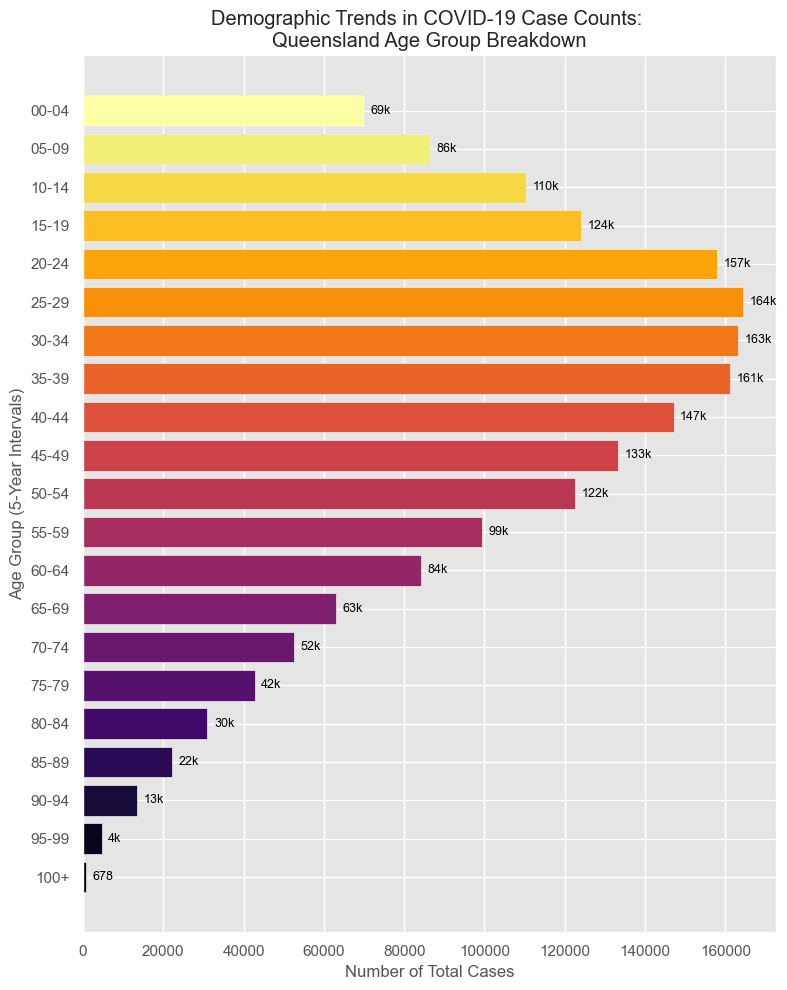

In [18]:
# Displaying age group distribution

# Predefined age order
age_order = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
    '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
    '80-84', '85-89', '90-94', '95-99', '100+']
age_order.reverse()

# Set age group as a categorical with custom age order
df_age['AGE_GROUP_5Y'] = pd.Categorical(df_age['AGE_GROUP_5Y'], categories=age_order, ordered=True)

# Count cases for each age group
counts = df_age['AGE_GROUP_5Y'].value_counts().reindex(age_order)

# Create gradient colors
cmap = plt.get_cmap("inferno")
colours = cmap(np.linspace(0, 1, len(counts)))

# Function to format numbers
def format_number(val):
    if val >= 1000:
        return f"{int(val // 1000)}k"
    else:
        return str(val)

plt.figure(figsize=(8, 10))
bars = plt.barh(age_order, counts.values, color=colours)

# Add value labels at the end of each bar
for bar, value in zip(bars, counts.values):
    plt.text(
        bar.get_width() + max(counts.values)*0.01,
        bar.get_y() + bar.get_height()/2,
        format_number(value), va='center',
        ha='left', fontsize=9, color='black'
    )

plt.title("Demographic Trends in COVID-19 Case Counts: \nQueensland Age Group Breakdown")
plt.xlabel('Number of Total Cases')
plt.ylabel('Age Group (5-Year Intervals)')
plt.tight_layout()
plt.show()

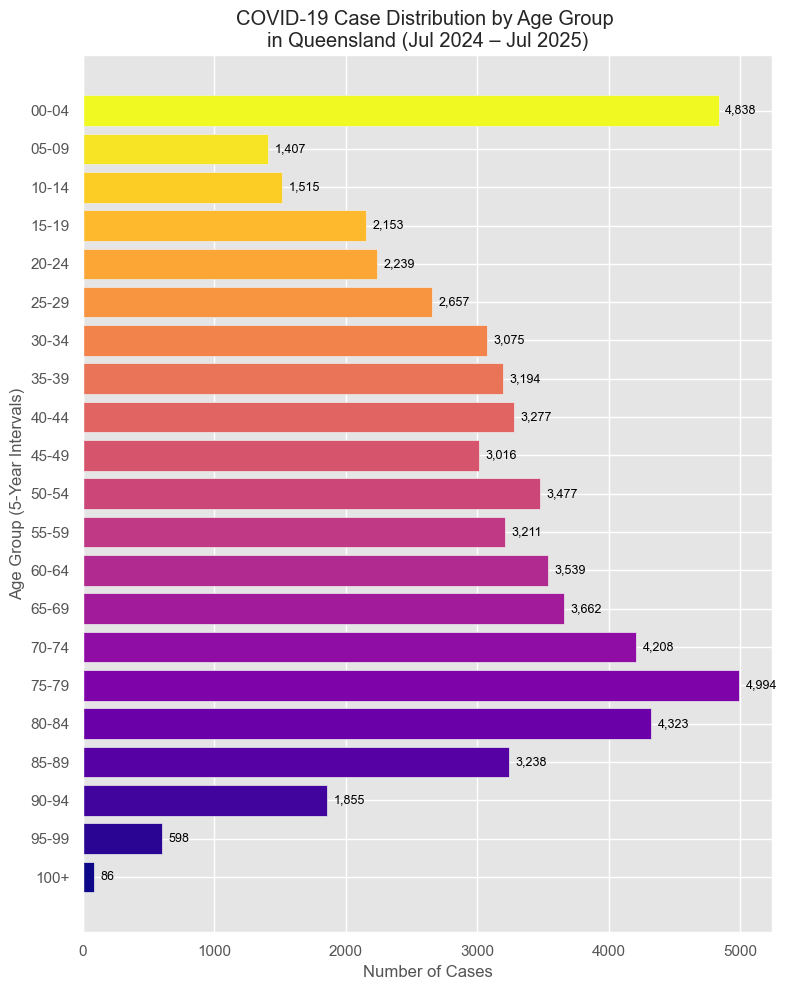

In [19]:
# Displaying age group distribution after filtering by date

# Filter data between July 2024 and July 2025
start_date = pd.Timestamp('2024-07-01')
end_date = pd.Timestamp('2025-07-31')
df_filtered_date = df_age[(df_age['NOTIFICATION_DATE'] >= start_date) & 
                          (df_age['NOTIFICATION_DATE'] <= end_date)].copy()

# Define and reverse age order
age_order = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
             '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
             '80-84', '85-89', '90-94', '95-99', '100+']
age_order.reverse()

# Set age group as categorical with custom order
df_filtered_date['AGE_GROUP_5Y'] = pd.Categorical(df_filtered_date['AGE_GROUP_5Y'], 
                                                  categories=age_order, ordered=True)

# Count cases for each age group
counts = df_filtered_date['AGE_GROUP_5Y'].value_counts().reindex(age_order)

# Create gradient colors
cmap = plt.get_cmap("plasma")
colours = cmap(np.linspace(0, 1, len(counts)))

# Function to format with comma as thousands separator
def format_number(val):
    return f"{val:,}"

# Plot horizontal bar chart
plt.figure(figsize=(8, 10))
bars = plt.barh(age_order, counts.values, color=colours)

# Add value labels at the end of each bar
for bar, value in zip(bars, counts.values):
    plt.text(
        bar.get_width() + max(counts.values)*0.01,
        bar.get_y() + bar.get_height()/2,
        format_number(value), va='center',
        ha='left', fontsize=9, color='black'
    )

plt.title("COVID-19 Case Distribution by Age Group \nin Queensland (Jul 2024 – Jul 2025)")
plt.xlabel("Number of Cases")
plt.ylabel("Age Group (5-Year Intervals)")
plt.tight_layout()
plt.show()

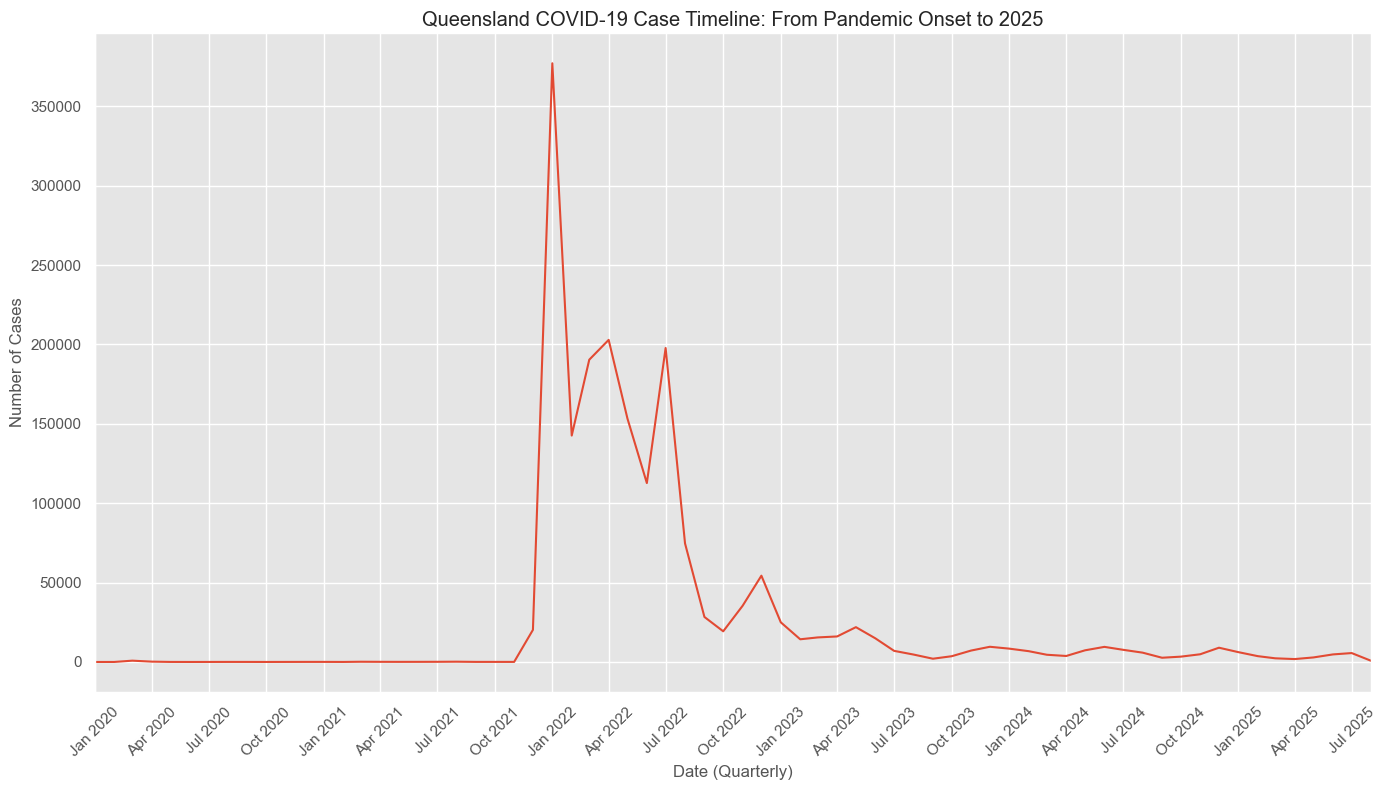

In [20]:
# Generate case timeline from the start of the pandemic

# Extract only the date and group by month for smoother trends
df_loc['MONTHLY_DATES'] = df_loc['NOTIFICATION_DATE'].dt.to_period('M').dt.to_timestamp()

# Group by MONTHLY_DATES
timeline_data = df_loc.groupby('MONTHLY_DATES').size().reset_index(name='Cases')

plt.figure(figsize=(14, 8))
sns.lineplot(data=timeline_data, x='MONTHLY_DATES', y='Cases')

# Format x-axis to show selected months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Jan, Apr, Jul, Oct
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2021

plt.title('Queensland COVID-19 Case Timeline: From Pandemic Onset to 2025')
plt.xlabel('Date (Quarterly)')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
# Removing the empty dates that was created from mdates
plt.xlim(timeline_data['MONTHLY_DATES'].min(), timeline_data['MONTHLY_DATES'].max()) 
plt.tight_layout()
plt.show()

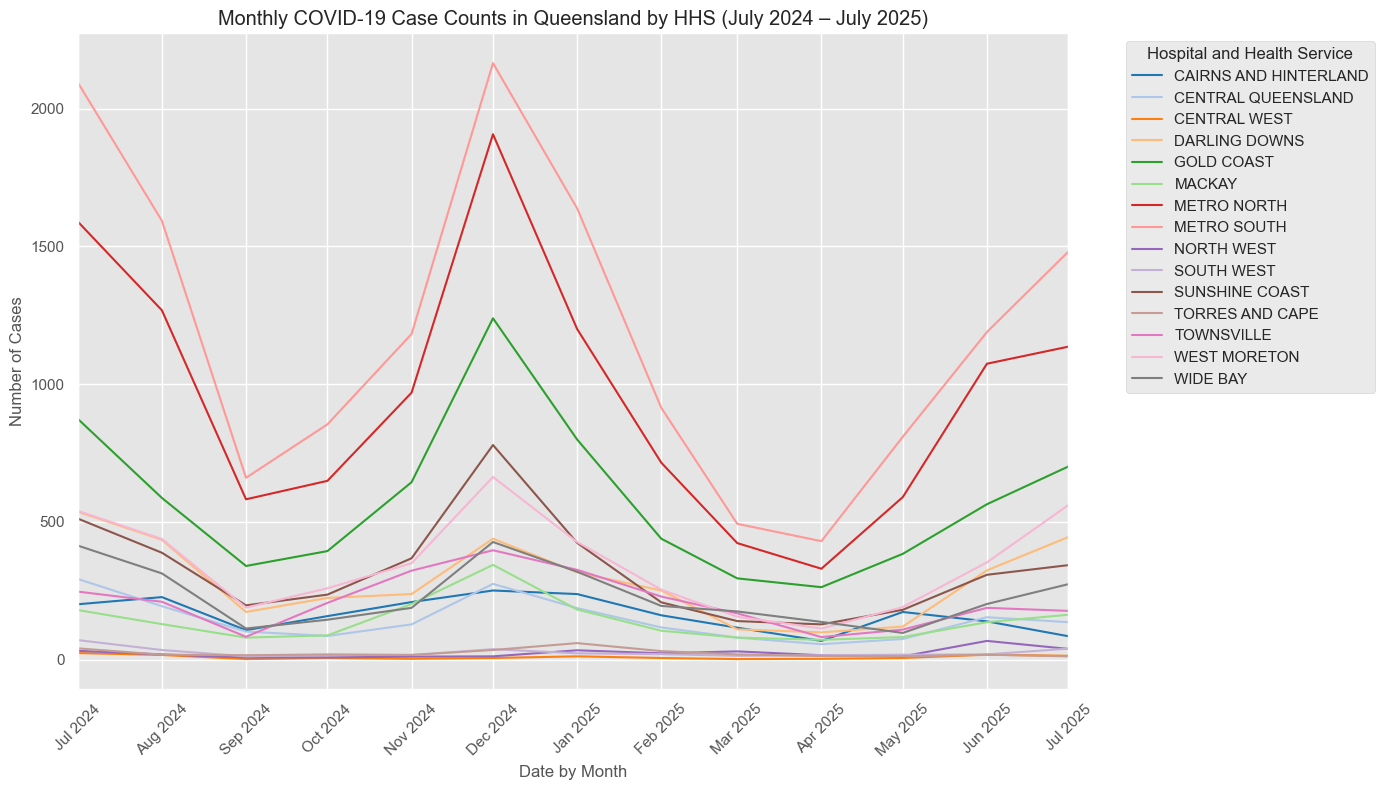

In [21]:
# Generate monthly cases from the start the last 12 month

# Convert NOTIFICATION_DATE to monthly period, then back to timestamp (first day of month)
df_loc['MONTHLY_DATES'] = df_loc['NOTIFICATION_DATE'].dt.to_period('M').dt.to_timestamp()

# Filter data between July 2024 and July 2025
start_date = pd.Timestamp('2024-07-01')
end_date = pd.Timestamp('2025-07-01')
df_filtered_date = df_loc[(df_loc['MONTHLY_DATES'] >= start_date) & (df_loc['MONTHLY_DATES'] <= end_date)]

# Group by DATE and HHS
timeline_data = df_filtered_date.groupby(['MONTHLY_DATES', 'HHS']).size().reset_index(name='Cases')

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=timeline_data, x='MONTHLY_DATES', y='Cases', hue='HHS', palette='tab20')

# Set monthly ticks (show every month)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Monthly COVID-19 Case Counts in Queensland by HHS (July 2024 – July 2025)')
plt.xlabel('Date by Month')
plt.ylabel('Number of Cases')
plt.legend(title='Hospital and Health Service', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.xlim(start_date, end_date)  # Ensures only the selected timeline is shown
plt.tight_layout()
plt.show()


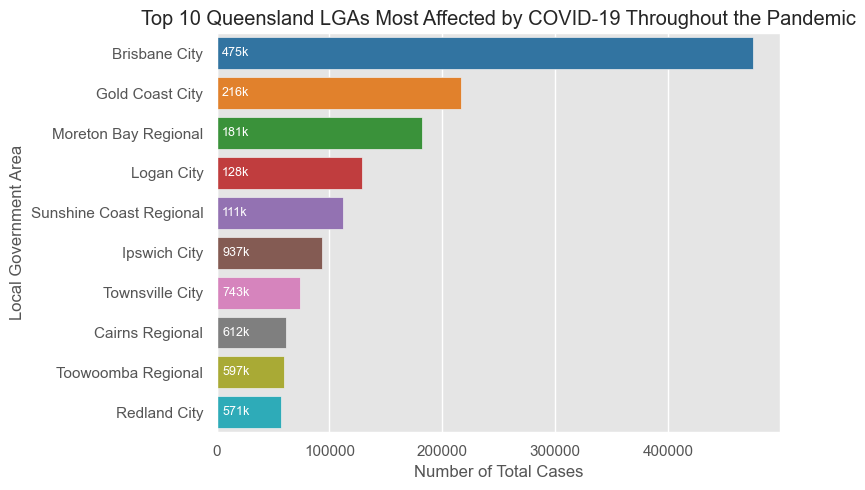

In [22]:
# Displaying COVID-19 case counts broken down by LGA
top_lga = df_loc['LGA_NAME'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=top_lga.values, y=top_lga.index, hue=top_lga.index,
    palette='tab10',legend=False, ax=ax
)

ax.set_title("Top 10 Queensland LGAs Most Affected by COVID-19 Throughout the Pandemic")
ax.set_xlabel("Number of Total Cases")
ax.set_ylabel("Local Government Area")

# Helper to take first 3 digits and append 'k'
def first3(n):
    s = str(int(n))
    return s[:3] + 'k' if len(s) > 3 else s

# Annotate at the left side of each bar
x_min, x_max = ax.get_xlim()
# small padding from the left edge
pad = 0.01 * (x_max - x_min)

for patch, val in zip(ax.patches, top_lga.values):
    y = patch.get_y() + patch.get_height() / 2
    x = x_min + pad
    ax.text(x, y, first3(val),va='center', 
            ha='left', fontsize=9, color='white')

plt.tight_layout()
plt.show()

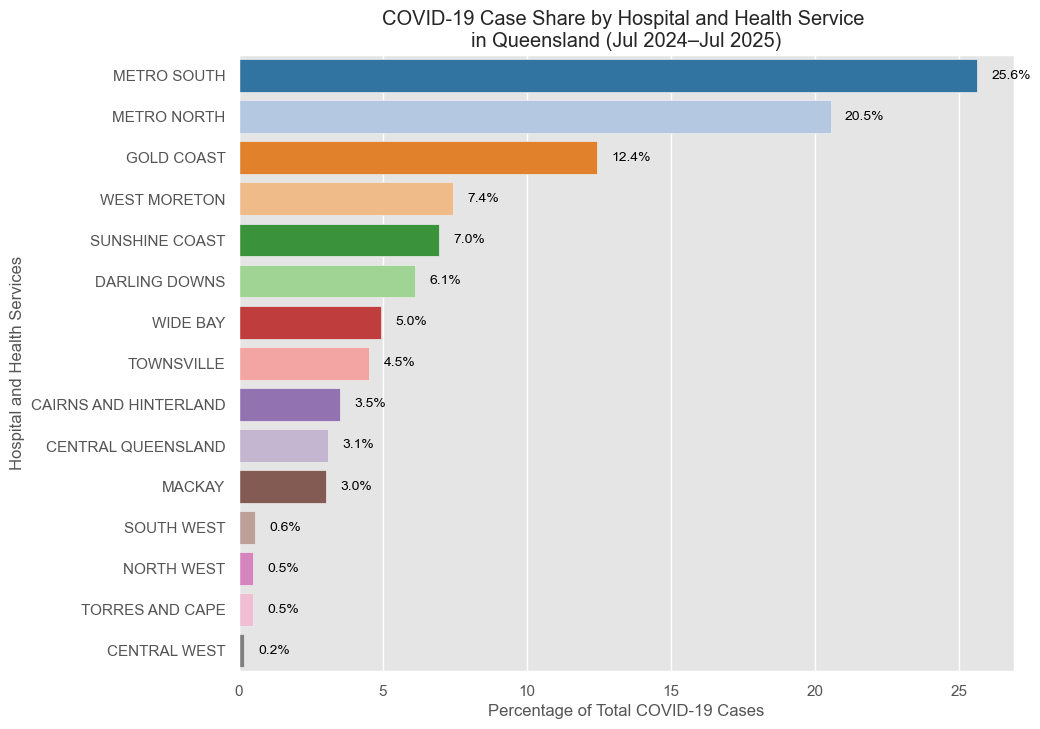

In [23]:
# Showing case percentages per HHS after applying date filter

# Filter data between July 2024 and July 2025
start_date = pd.Timestamp('2024-07-01')
end_date = pd.Timestamp('2025-07-31')
df_filtered_date = df_loc[(df_loc['MONTHLY_DATES'] >= start_date) & 
                          (df_loc['MONTHLY_DATES'] <= end_date)]

# Count occurrences of each HHS
hhs_counts = df_filtered_date['HHS'].value_counts()

# Convert counts to percentages
hhs_percentages = (hhs_counts / hhs_counts.sum()) * 100

# Sort for better visualisation
hhs_percentages = hhs_percentages.sort_values(ascending=False)

# Plot the percentages
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=hhs_percentages.values, y=hhs_percentages.index, 
                 hue=hhs_percentages.index, palette='tab20', 
                 dodge=False, legend=False)
# Add percentage labels to the end of each bar
for i, (value, name) in enumerate(zip(hhs_percentages.values, 
                                      hhs_percentages.index)):
    ax.text(value + 0.5, i, f"{value:.1f}%", 
            va='center', ha='left', 
            fontsize=10, color='black')
plt.title("COVID-19 Case Share by Hospital and Health Service \nin Queensland (Jul 2024–Jul 2025)")
plt.xlabel("Percentage of Total COVID-19 Cases")
plt.ylabel("Hospital and Health Services")
plt.show()

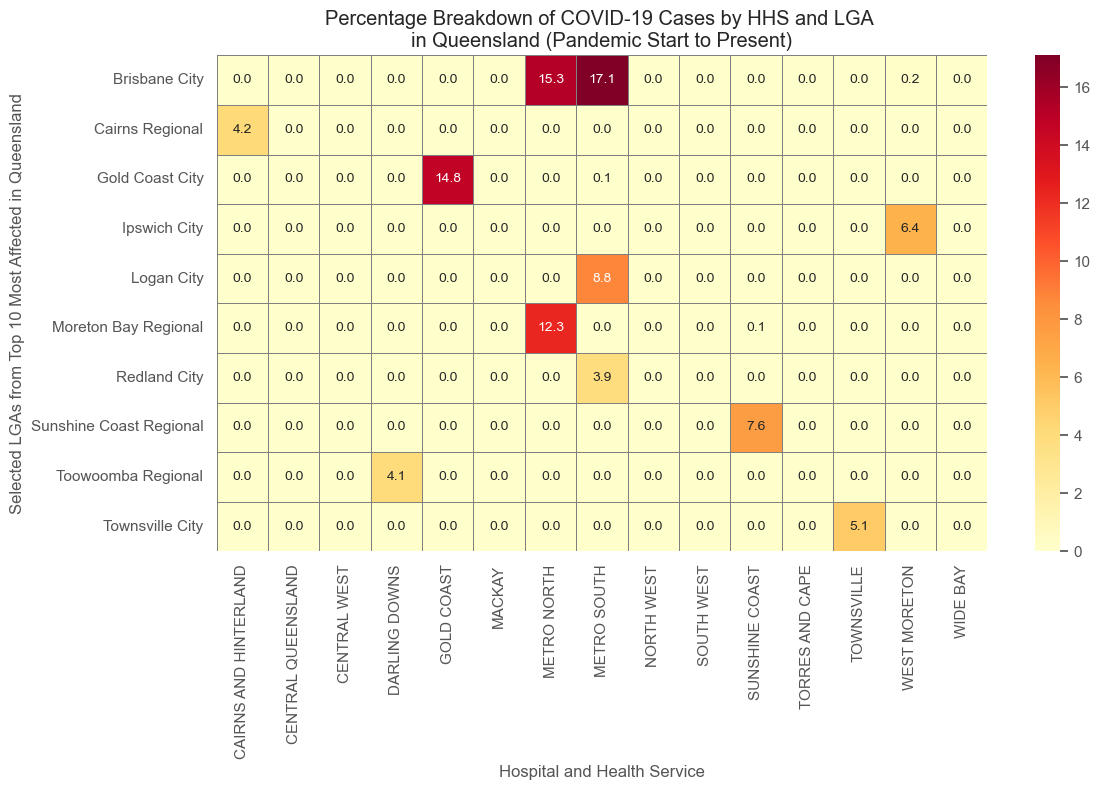

In [24]:
# Visualising case concentration using a heatmap of HHS vs selected LGAs

# Define the LGAs you want to include
selected_lgas = ['Brisbane City', 'Gold Coast City', 'Moreton Bay Regional', 'Logan City',
    'Sunshine Coast Regional', 'Ipswich City', 'Townsville City',
    'Cairns Regional', 'Toowoomba Regional', 'Redland City']

# Create the counted DataFrame
df_counts = (df_loc[['HHS', 'LGA_NAME']].value_counts()
             .reset_index(name='count').sort_values(by='count', ascending=False))

# Filter to only selected LGAs
df_filtered_lgas = df_counts[df_counts['LGA_NAME'].isin(selected_lgas)]

# Pivot the data for heatmap
heatmap_data = df_filtered_lgas.pivot(index='LGA_NAME', columns='HHS', values='count').fillna(0)

# Convert counts to percentage of total
heatmap_percent = (heatmap_data / heatmap_data.values.sum()) * 100

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_percent, annot=True, fmt='.1f', 
            cmap='YlOrRd', linewidths=0.5, linecolor='gray')
plt.title('Percentage Breakdown of COVID-19 Cases by HHS and LGA \nin Queensland (Pandemic Start to Present)')
plt.xlabel('Hospital and Health Service')
plt.ylabel('Selected LGAs from Top 10 Most Affected in Queensland')
plt.tight_layout()
plt.show()

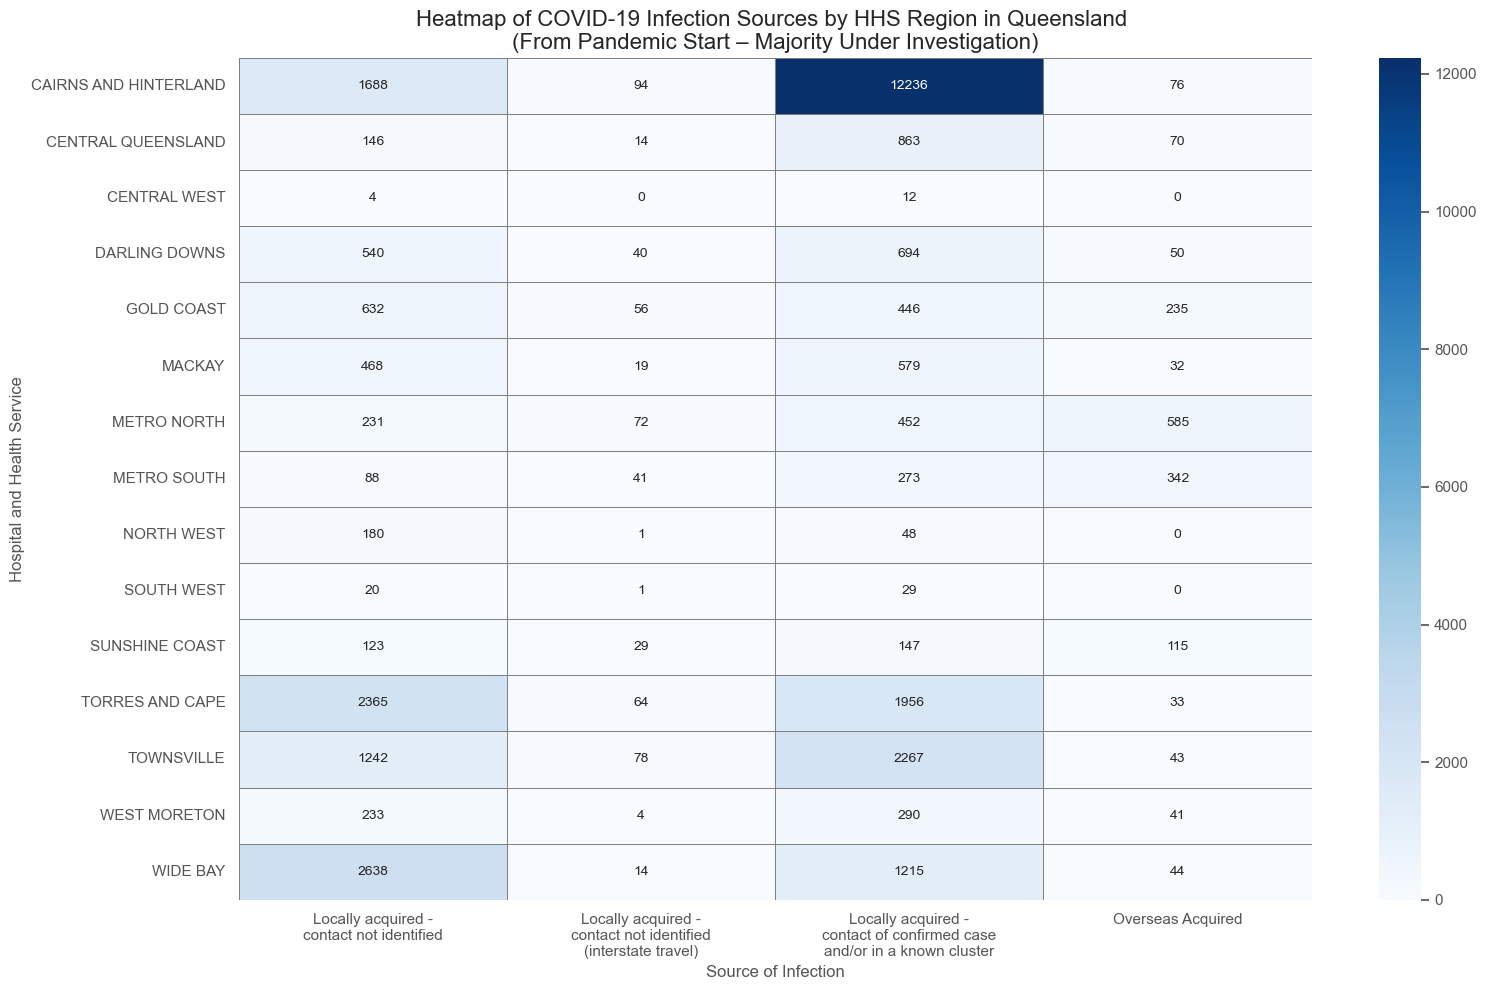

In [25]:
# Visualising COVID-19 case origins by HHS and source of infection

# Create a new column with line-broken versions of long SOURCE_INFECTION values
df_loc['SOURCE_INFECTION_BREAK_LINE'] = df_loc['SOURCE_INFECTION'].replace({
    'Locally acquired - contact of confirmed case and/or in a known cluster': 
    'Locally acquired -\ncontact of confirmed case\nand/or in a known cluster',
    'Locally acquired - contact not identified': 
    'Locally acquired -\ncontact not identified',
    'Locally acquired - contact not identified interstate travel': 
    'Locally acquired -\ncontact not identified\n(interstate travel)'
})

# Removing "Under Investigation" and "Not Applicable" data
filtered_df = df_loc[~df_loc['SOURCE_INFECTION_BREAK_LINE'].isin(["Under Investigation", "Not Applicable"])]

# Grouping the filtered data
heatmap_data = filtered_df.groupby(['HHS', 'SOURCE_INFECTION_BREAK_LINE']).size().reset_index(name='Cases')

# Pivot the data: rows = HHS, columns = SOURCE_INFECTION
heatmap_matrix = heatmap_data.pivot(index='HHS', columns='SOURCE_INFECTION_BREAK_LINE', values='Cases').fillna(0)

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_matrix, cmap='Blues', annot=True, 
            fmt='g', linewidths=0.5, linecolor='gray')

plt.title('Heatmap of COVID-19 Infection Sources by HHS Region in Queensland \n(From Pandemic Start – Majority Under Investigation)', 
          fontsize=16)
plt.xlabel('Source of Infection')
plt.ylabel('Hospital and Health Service')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()